In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import kmedoids
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [2]:
def create_comparation_table_clustering(pred, X, labels, dict_class_types, class_label):
    ''' Create a dataframe with the values of all the features (denoted by X) and the label results
    of the clustering algorithm, plus class names (table denoted by yhat). Also, returns a comparision table
    with the presence of each class type with each cluster type, if present.
    
    Args:
        - pred (pd.DataFrame): class prediction result
        - X (pd.DataFrame): features dataset, input for prediction
        - labels (pd.Series): true labels of the original dataset
        - dict_class_types (dict): dict with keys being the true class number and values with names.
        - class_label (pd.DataFrame): dataframe with information about data classes (number and name)
        
    Returns:
        - yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model
        - comp_table (pd.DataFrame): dataframe with the results of the clustering model, plus calculations of the presence.
        
        
    '''    
    
    # Create dataframe with features plus prediction values
    yhat = X.copy()
    yhat['cluster_label'] = pred
    yhat['class_label'] = labels
    yhat['class_name'] = yhat['class_label'].replace(dict_class_types)
    
    # Create comparision table with results
    check_labels_w_names = yhat.groupby(['class_label','cluster_label']).size().reset_index()
    check_labels_w_names['class_name'] = check_labels_w_names['class_label'].replace(dict_class_types)
    check_labels_w_names = check_labels_w_names.set_index(['class_name', 'class_label'])
    check_labels_w_names = pd.merge(check_labels_w_names.reset_index(), class_label[['Class_Number', 'Number_Of_Animal_Species_In_Class']], 
            'left', left_on = 'class_label', right_on = 'Class_Number')
    check_labels_w_names = check_labels_w_names.rename({'Number_Of_Animal_Species_In_Class': 'class_total_number',
                                                        0: 'cluster_total_number'}, axis = 1)
    check_labels_w_names['presence_relative_to_class'] = np.round(check_labels_w_names['cluster_total_number']/check_labels_w_names['class_total_number'],3)
    comp_table = check_labels_w_names.set_index(['class_name', 'class_label'])

    return yhat, comp_table

In [3]:
def compute_distance_matrix(centroids_clusters, centroids_classes):
    """ 
    Calculation of the distance between two vectors.
    
    Args:
        centroids_clusters (pd.DataFrame): matrix of the centroids for each cluster.
        centroids_classes (pd.DataFrame): matrix of the centroids for each of the classes.
        
    Returns:
        dmatrix (pd.DataFrame): distance matrix between centroids of each cluster with each class.
    
    """
    

    distance_matrix = []
    for cluster in centroids_clusters.index:
        distance_cluster_list = []
        for class_centroid in centroids_classes.index:
            eu_distance = np.linalg.norm(centroids_clusters.loc[cluster] - centroids_classes.loc[class_centroid])
            distance_cluster_list.append(eu_distance)
        distance_matrix.append(distance_cluster_list)
        
    dmatrix = pd.DataFrame(distance_matrix, 
                           index = list(centroids_clusters.index),
                           columns = list(centroids_classes.index))
    
    return dmatrix

In [4]:
def assign_clusters_distance(dmatrix):
    
    """
    Assign based on Euclidean distance between centroids the most similar cluster
    
    Args:
        dmatrix (pd.DataFrame): dataframe with cluster numbers as indexes and class labels as columns. Values are the distances
                                previously computed
    
    Returns:
        cluster_assignment (pd.Series):  assignment of each cluster for each class label.
    
    """

    cluster_assignment = dmatrix.idxmin()
    # print(len(dmatrix.columns))
    if len(cluster_assignment.unique()) != len(dmatrix.columns):
        print('There are repeated assignments for one or several classes!!!')
        
    # todo: create alg for assign based on most near centroid
    
    return cluster_assignment
    
    

In [5]:
def classification_metrics(yhat, assignment):
    """
    Computation of the a regular classification model based on a confusion matrix
    
    Args:
        yhat (pd.DataFrame): dataframe with all the feature values plus the results of the model
        assignment (dict): dictionary with the cluster number (keys) and their corresponding true class name (values). 
    
    Returns:
        metrics_result_df (pd.DataFrame): result table with metrics
    
    """
    
    metrics_result_df = pd.DataFrame(columns = ["class_name","Accuracy", "Precision", "Specificity", "Recall", "F1"])
    
    for cluster_number, class_name in assignment.items():
        predicted_bool_col = yhat["cluster_label"] == cluster_number
        true_bool_col = yhat["class_name"] == class_name
        acc_sc = accuracy_score(true_bool_col, predicted_bool_col)
        pre_sc = precision_score(true_bool_col, predicted_bool_col)
        specificity_sc = recall_score(true_bool_col, predicted_bool_col, pos_label = 0)
        recall_sc = recall_score(true_bool_col, predicted_bool_col)
        f1_sc = f1_score(true_bool_col, predicted_bool_col)
        
        metrics_result_df.loc[cluster_number] = [class_name, acc_sc, pre_sc, specificity_sc, recall_sc, f1_sc]
        
        
    return metrics_result_df    

In [6]:
def assign_clusters_distance(dmatrix):
    
    """
    Assign based on Euclidean distance between centroids the most similar cluster
    
    Args:
        dmatrix (pd.DataFrame): dataframe with cluster numbers as indexes and class labels as columns. Values are the distances
                                previously computed
    
    Returns:
        cluster_assignment (pd.Series):  assignment of each cluster for each class label.
    
    """
    
    dm = dmatrix.copy()
    assign_tuples = []

    while len(dm) > 0:
        
        # We get the class that has the min distance computed
        minimum_distance_class = dm.min().idxmin()
        # Get the cluster index relative to that min value
        min_index = dm[minimum_distance_class].idxmin()

        # Save the tuple (index, class)
        assignment_tuple = (int(min_index), minimum_distance_class)
        assign_tuples.append(assignment_tuple)
        dm = dm.drop(min_index)
        dm = dm.drop(minimum_distance_class, axis = 1)
        
    return dict(assign_tuples)
    

In [7]:
def plot_chars_heatmap(data, title = None):
    """
    asdasd
    """
    
    plt.figure(figsize = (7,7))

    ax = sns.heatmap(data = data, annot = True)
    ax.set_title(title)

    plt.show()

In [8]:
def aggregate_features_cluster_centers(zoo_data, columns, cluster_centers = None, index = None):
    """
    
    """
    
    # --- For graphs ---
    agg_clusters = pd.DataFrame(cluster_centers , index = index,columns = columns).astype('float32').reset_index().rename({'index': 'label_cluster'}, axis = 1)
    # --- For computation
    centroids_classes = zoo_data.drop(['class_type', 'animal_name'], axis = 1).groupby(['class_names']).mean()
    
    return agg_clusters, centroids_classes

# Data

In [9]:
zoo = pd.read_csv('../data/zoo.csv')
class_label = pd.read_csv('../data/class.csv')
zm = pd.read_pickle('../data/zoo_mod.pkl')

In [10]:
non_boolean_features = ['legs', 'class_type']
numerical_features = ['legs']
animal_names_column = ['animal_name']


col_set = set(list(zoo.columns))
boolean_features = col_set-set(non_boolean_features+animal_names_column)
boolean_features_w_class = col_set - set(numerical_features+animal_names_column)

dict_class_types = dict(zip(class_label['Class_Number'], class_label['Class_Type']))

# Modeling
- Let's see what we can do with baseline clustering models.
- Then, if needed, we will do more wrangling, feature engineering, PCA or other transformations to the data if the result isn't the best.

## K-Means

- Prepare the data for input in algorithms

In [11]:
labels = zm['class_type']
#X = zm.drop(['animal_name', 'class_type', 'class_names', 'hair', 'predator', 'venomous', 'domestic', 'catsize'], axis = 1).copy()
X = zm.drop(['animal_name', 'class_type', 'class_names'], axis = 1).copy()


In [12]:
# From the project description, we know that we have 7 clusters.

k = 7
kmeans = KMeans(n_clusters = k, random_state=42)
y_pred = kmeans.fit_predict(X)

c:\Users\faarc\anaconda3\envs\ml_da\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\faarc\anaconda3\envs\ml_da\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


- We have the centroids

In [13]:
kmeans.cluster_centers_[0]

array([ 9.09090909e-02,  9.09090909e-01,  9.09090909e-01,  9.09090909e-02,
        8.18181818e-01,  4.54545455e-02,  4.09090909e-01,  9.09090909e-02,
        1.00000000e+00,  1.00000000e+00, -2.77555756e-17, -5.55111512e-17,
        2.00000000e+00,  1.00000000e+00,  1.36363636e-01,  2.72727273e-01,
        1.36363636e-01])

In [14]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

- For the first run, we have pretty good results. Our model could clusterize correctly the Bird, Fish and Amphibian classes.
- We can see that for mammals, there's also a good presence on cluster label 1 (being 36 of this label), but we still have some missclasified clusters.
- Regarding Reptiles and Invertebrate, we don't have the best result, but we can try doing some other things to increase even more the quality of our model.    

In [15]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     2             1   
             1                        1                    36             1   
             1                        2                     3             1   
Bird         2                        0                    20             2   
Reptile      3                        1                     1             3   
             3                        2                     1             3   
             3                        4                     2             3   
             3                        5                     1             3   
Fish         4                        2                    13             4   
Amphibian    5                        5                     4             5   
Bug          6                        3                     2             6   
             6                        6                     6             6   
Invertebrate 7                        3                     4             7   
             7                        4                     4             7   
             7                        5                     2             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.049  
             1                            41                       0.878  
             1                            41                       0.073  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.200  
             3                             5                       0.200  
             3                             5                       0.400  
             3                             5                       0.200  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       0.250  
             6                             8                       0.750  
Invertebrate 7                            10                       0.400  
             7                            10                       0.400  
             7                            10                       0.200

- Podemos ver que los labels mal clasificados en Mammals corresponden a animales que son mamíferos, pero que tienen muchas más características propias de animales de otra clases.

- Por ejemplos:
    - Tenemos delfines, porpoises y seals. Si nos damos cuenta, todos estos animales son mamíferos (maman), pero tienen muchas más cualidades de un pescado (posee fins, no tiene piernas, acuático, no tienen pelo menos los seals)
    - Lo mismo con los murciélagos y vampiros, aunque maman, tienen características propias de una ave.

In [16]:
zm['animal_name'].loc[(yhat[(yhat['class_name'] == 'Mammal') & (yhat['cluster_label'] != 1)].index)]

19     dolphin
27    fruitbat
66    porpoise
74        seal
93     vampire
Name: animal_name, dtype: object

- Podemos ver que no todas las variables son utilizadas para este grupo más utilizado. Podremos filtrar estas variables y utilizar las que más representan a este grupo?

In [17]:
yhat[yhat['cluster_label'] == 1].describe().loc['mean'].sort_values(ascending = False)

legs             3.729730
class_label      1.054054
breathes         1.000000
cluster_label    1.000000
backbone         1.000000
hair             0.972973
milk             0.972973
toothed          0.945946
land             0.918919
tail             0.864865
catsize          0.810811
predator         0.513514
domestic         0.216216
aquatic          0.081081
eggs             0.054054
fins             0.027027
feathers         0.000000
venomous         0.000000
airborne         0.000000
Name: mean, dtype: float64

- Let's check if we have the same situation with another class

In [18]:
yhat[(yhat['class_name'] == 'Reptile')]

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,land,cluster_label,class_label,class_name
62,0,0,1,0,0,0,1,1,1,1,1,0,0,1,0,0,1,4,3,Reptile
76,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,0,2,3,Reptile
80,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,0,1,4,3,Reptile
90,0,0,1,0,0,0,0,0,1,1,0,0,4,1,0,1,1,1,3,Reptile
91,0,0,1,0,0,0,1,1,1,1,0,0,4,1,0,0,1,5,3,Reptile


In [19]:
zm[(zm['feathers'] == 0) & (zm['fins'] == 0) & (zm['hair'] == 0) & (zm['legs'].isin([4,0])) & (zm['backbone'] == 1)]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type,class_names,land
25,frog,0,0,1,0,0,1,1,1,1,1,0,0,4,0,0,0,5,Amphibian,0
26,frog,0,0,1,0,0,1,1,1,1,1,1,0,4,0,0,0,5,Amphibian,0
52,newt,0,0,1,0,0,1,1,1,1,1,0,0,4,1,0,0,5,Amphibian,0
62,pitviper,0,0,1,0,0,0,1,1,1,1,1,0,0,1,0,0,3,Reptile,1
76,seasnake,0,0,0,0,0,1,1,1,1,0,1,0,0,1,0,0,3,Reptile,0
80,slowworm,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,0,3,Reptile,1
89,toad,0,0,1,0,0,1,0,1,1,1,0,0,4,0,0,0,5,Amphibian,0
90,tortoise,0,0,1,0,0,0,0,0,1,1,0,0,4,1,0,1,3,Reptile,1
91,tuatara,0,0,1,0,0,0,1,1,1,1,0,0,4,1,0,0,3,Reptile,1


In [20]:
zm['animal_name'].loc[(yhat[(yhat['class_name'] == 'Reptile')].index)]

62    pitviper
76    seasnake
80    slowworm
90    tortoise
91     tuatara
Name: animal_name, dtype: object

In [21]:
centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, kmeans.cluster_centers_)

- We see that for some classes, we calculated a very close approximation, comparing it with the mean values for each group and their respective feature.
- For example, for Mammals we see a strong correlation of features with the group 2 cluster label. Also Bird with cluster 1, Fish with group 3, Amphibian with group 6, Bug with group 0.
- Group 4 and 5 contains a weird mix of every feature. You can see it in the table we computed; label 4 is also present in the mammal label, while label 5 is around invertebrate and reptile classes.
- Maybe we can delete some features to make the model simpler and have better results?

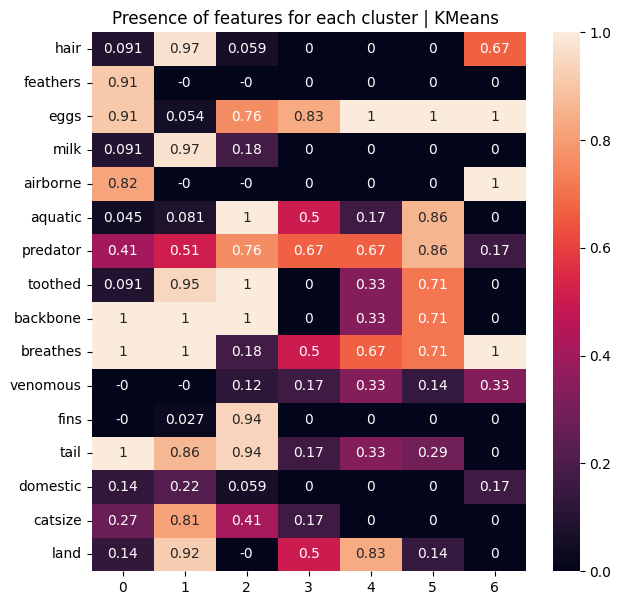

In [22]:
plot_chars_heatmap(np.round(centroids_clusters.drop(["label_cluster", "legs"], axis = 1), 6).T, 
                   "Presence of features for each cluster | KMeans ")

In [23]:
centroids_clusters

,label_cluster,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,land
0,0,0.090909,9.090909e-01,0.909091,9.090909e-02,8.181818e-01,0.045455,0.409091,0.090909,1.000000,1.000000,-2.775558e-17,-5.551115e-17,2.000000,1.000000e+00,0.136364,0.272727,1.363636e-01
1,1,0.972973,-1.110223e-16,0.054054,9.729730e-01,-1.942890e-16,0.081081,0.513514,0.945946,1.000000,1.000000,-4.163336e-17,2.702703e-02,3.729730,8.648649e-01,0.216216,0.810811,9.189189e-01
2,2,0.058824,-2.775558e-17,0.764706,1.764706e-01,-1.110223e-16,1.000000,0.764706,1.000000,1.000000,0.176471,1.176471e-01,9.411765e-01,0.000000,9.411765e-01,0.058824,0.411765,-1.665335e-16
3,3,0.000000,2.775558e-17,0.833333,5.551115e-17,0.000000e+00,0.500000,0.666667,0.000000,0.000000,0.500000,1.666667e-01,2.775558e-17,6.666667,1.666667e-01,0.000000,0.166667,5.000000e-01
4,4,0.000000,2.775558e-17,1.000000,5.551115e-17,0.000000e+00,0.166667,0.666667,0.333333,0.333333,0.666667,3.333333e-01,2.775558e-17,0.000000,3.333333e-01,0.000000,0.000000,8.333333e-01
5,5,0.000000,2.775558e-17,1.000000,5.551115e-17,0.000000e+00,0.857143,0.857143,0.714286,0.714286,0.714286,1.428571e-01,2.775558e-17,4.142857,2.857143e-01,0.000000,0.000000,1.428571e-01
6,6,0.666667,2.775558e-17,1.000000,5.551115e-17,1.000000e+00,0.000000,0.166667,0.000000,0.000000,1.000000,3.333333e-01,2.775558e-17,6.000000,1.110223e-16,0.166667,0.000000,0.000000e+00


In [24]:
centroids_classes

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,land
class_names,,,,,,,,,,,,,,,,,
Amphibian,0.00000,0.0,1.00000,0.0,0.00000,1.000000,0.750000,1.00000,1.0,1.0,0.250000,0.000000,4.000000,0.250000,0.000000,0.000000,0.000000
Bird,0.00000,1.0,1.00000,0.0,0.80000,0.050000,0.450000,0.00000,1.0,1.0,0.000000,0.000000,2.000000,1.000000,0.150000,0.300000,0.150000
Bug,0.50000,0.0,1.00000,0.0,0.75000,0.000000,0.125000,0.00000,0.0,1.0,0.250000,0.000000,6.000000,0.000000,0.125000,0.000000,0.250000
Fish,0.00000,0.0,1.00000,0.0,0.00000,1.000000,0.692308,1.00000,1.0,0.0,0.076923,1.000000,0.000000,1.000000,0.076923,0.307692,0.000000
Invertebrate,0.00000,0.0,0.90000,0.0,0.00000,0.600000,0.800000,0.00000,0.0,0.3,0.200000,0.000000,3.700000,0.100000,0.000000,0.100000,0.400000
Mammal,0.95122,0.0,0.02439,1.0,0.04878,0.146341,0.536585,0.97561,1.0,1.0,0.000000,0.097561,3.365854,0.853659,0.195122,0.780488,0.804878
Reptile,0.00000,0.0,0.80000,0.0,0.00000,0.200000,0.800000,0.80000,1.0,0.8,0.400000,0.000000,1.600000,1.000000,0.000000,0.200000,0.800000


In [25]:
dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment

{0: 'Bird',
 2: 'Fish',
 1: 'Mammal',
 6: 'Bug',
 5: 'Amphibian',
 4: 'Reptile',
 3: 'Invertebrate'}

In [26]:
classification_metrics(yhat, assignment)

,class_name,Accuracy,Precision,Specificity,Recall,F1
0,Bird,0.980198,0.909091,0.975309,1.000000,0.952381
2,Fish,0.960396,0.764706,0.954545,1.000000,0.866667
1,Mammal,0.940594,0.972973,0.983333,0.878049,0.923077
6,Bug,0.980198,1.000000,1.000000,0.750000,0.857143
5,Amphibian,0.970297,0.571429,0.969072,1.000000,0.727273
4,Reptile,0.930693,0.333333,0.958333,0.400000,0.363636
3,Invertebrate,0.920792,0.666667,0.978022,0.400000,0.500000


- We'll first try with these classes: predator, catsize, venomous, domestic
- Why these features? Mainly because they do not offer much information to the model. We can see that for each class the presence of each of these features do not represent critically many classes. (todo: explain this better)

## DBSCAN

- DBSCAN is a density based model. We need to initialize it first.
- We'll try to search for a combination of eps and min_samples (hyperparameters) that fits the k = 7 number of clusters.

In [27]:
# todo: method for getting eps and min_sample, not arbitrary

hyperp_search_tuples = []
for ep_val in range(10):
    for ms_val in range(30):
        dbsc = DBSCAN(eps = ep_val+1,min_samples = ms_val+1).fit_predict(X)
        unique_clusters = len(set(dbsc))
        hyperp_search_tuples.append((ep_val+1,ms_val+1,unique_clusters))
        # print(f'Unique values: {len(set(dbsc))}')

result_hyperp_search = pd.DataFrame(hyperp_search_tuples, columns = ['eps', "min_samples", "unique_clusters"])

In [28]:
eps, min_samples, unique_clusters = list(result_hyperp_search[result_hyperp_search['unique_clusters'] == 7].iloc[0])
print(eps,min_samples)

dbsc = DBSCAN(eps = eps,min_samples = min_samples)
y_pred_dbsc = dbsc.fit_predict(X)

1 4


In [29]:
yhat, comp_table = create_comparation_table_clustering(y_pred_dbsc, X, labels, dict_class_types, class_label)

In [30]:
centroids_clusters_db = yhat.drop(["class_name"], axis = 1).groupby(["cluster_label"]).mean()[X.columns]
centroids_clusters_db = pd.DataFrame(data = np.array(centroids_clusters_db), 
             index = list(centroids_clusters_db.index),
             columns = centroids_clusters_db.columns)

centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, 
                                                                        np.array(centroids_clusters_db),
                                                                        list(centroids_clusters_db.index))



In [31]:
dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment_new_label = dict(zip(assignment.keys(),[f'{x[0]} ({x[1]})' for x in assignment.items()]))
gb_clusters = centroids_clusters.drop(["legs", "label_cluster"], axis = 1)
gb_clusters.index = [assignment_new_label[i] for i in centroids_clusters["label_cluster"]]
assignment
assignment_new_label

{3: '3 (Amphibian)',
 1: '1 (Fish)',
 2: '2 (Bird)',
 4: '4 (Bug)',
 0: '0 (Mammal)',
 -1: '-1 (Reptile)',
 5: '5 (Invertebrate)'}

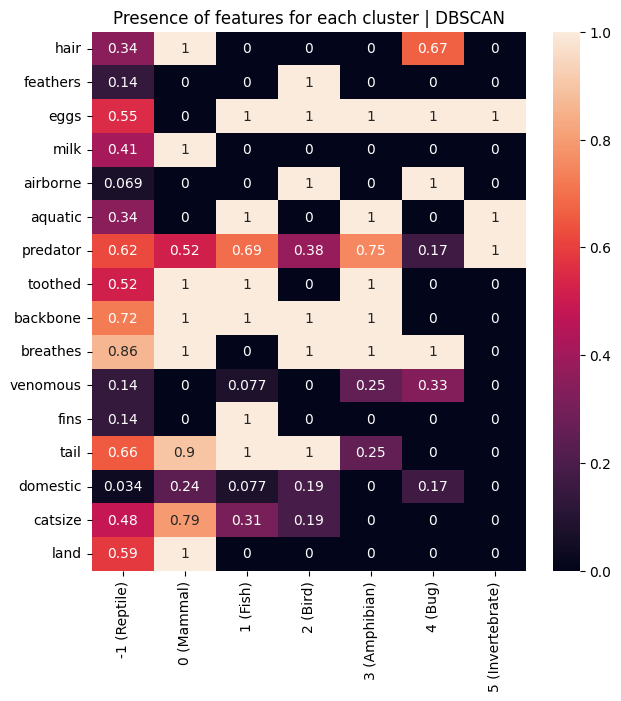

In [32]:
plot_chars_heatmap(gb_clusters.T, 
                   "Presence of features for each cluster | DBSCAN")

In [33]:
classification_metrics(yhat, assignment)

,class_name,Accuracy,Precision,Specificity,Recall,F1
3,Amphibian,1.000000,1.000000,1.00,1.000000,1.000000
1,Fish,1.000000,1.000000,1.00,1.000000,1.000000
2,Bird,0.960396,1.000000,1.00,0.800000,0.888889
4,Bug,0.980198,1.000000,1.00,0.750000,0.857143
0,Mammal,0.881188,1.000000,1.00,0.707317,0.828571
-1,Reptile,0.762376,0.172414,0.75,1.000000,0.294118
5,Invertebrate,0.940594,1.000000,1.00,0.400000,0.571429


## KMedoids

In [34]:
from sklearn.metrics.pairwise import euclidean_distances

In [35]:

km = kmedoids.KMedoids(7, method = "pam",random_state=42)
y_pred_km = km.fit_predict(euclidean_distances(X))

In [36]:
yhat, comp_table = create_comparation_table_clustering(y_pred_km, X, labels, dict_class_types, class_label)

In [37]:
centroids_clusters_km = yhat.drop(["class_name"], axis = 1).groupby(["cluster_label"]).mean()[X.columns]
centroids_clusters_km = pd.DataFrame(data = np.array(centroids_clusters_km), 
             index = list(centroids_clusters_km.index),
             columns = centroids_clusters_km.columns)

centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, 
                                                                        np.array(centroids_clusters_km),
                                                                        list(centroids_clusters_km.index))

In [38]:
dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment_new_label = dict(zip(assignment.keys(),[f'{x[0]} ({x[1]})' for x in assignment.items()]))
gb_clusters = centroids_clusters.drop(["legs", "label_cluster"], axis = 1)
gb_clusters.index = [assignment_new_label[i] for i in centroids_clusters["label_cluster"]]
assignment
assignment_new_label

{1: '1 (Bird)',
 2: '2 (Amphibian)',
 5: '5 (Bug)',
 3: '3 (Fish)',
 4: '4 (Mammal)',
 0: '0 (Reptile)',
 6: '6 (Invertebrate)'}

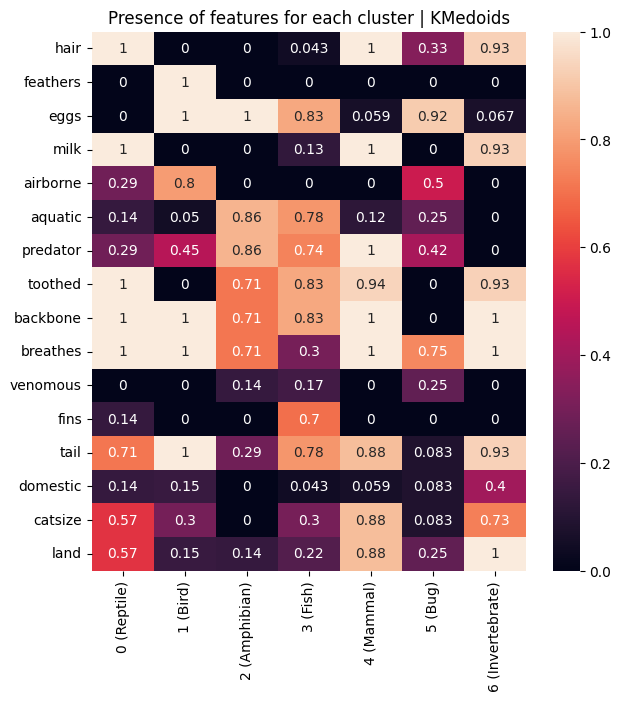

In [39]:
plot_chars_heatmap(gb_clusters.T,   
                   "Presence of features for each cluster | KMedoids")

In [40]:
classification_metrics(yhat, assignment)

,class_name,Accuracy,Precision,Specificity,Recall,F1
1,Bird,1.000000,1.000000,1.000000,1.000000,1.000000
2,Amphibian,0.970297,0.571429,0.969072,1.000000,0.727273
5,Bug,0.960396,0.666667,0.956989,1.000000,0.800000
3,Fish,0.900990,0.565217,0.886364,1.000000,0.722222
4,Mammal,0.762376,1.000000,1.000000,0.414634,0.586207
0,Reptile,0.881188,0.000000,0.927083,0.000000,0.000000
6,Invertebrate,0.752475,0.000000,0.835165,0.000000,0.000000


In [41]:
assignment

{1: 'Bird',
 2: 'Amphibian',
 5: 'Bug',
 3: 'Fish',
 4: 'Mammal',
 0: 'Reptile',
 6: 'Invertebrate'}

In [42]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     7             1   
             1                        3                     3             1   
             1                        4                    17             1   
             1                        6                    14             1   
Bird         2                        1                    20             2   
Reptile      3                        2                     1             3   
             3                        3                     3             3   
             3                        6                     1             3   
Fish         4                        3                    13             4   
Amphibian    5                        2                     4             5   
Bug          6                        5                     8             6   
Invertebrate 7                        2                     2             7   
             7                        3                     4             7   
             7                        5                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.171  
             1                            41                       0.073  
             1                            41                       0.415  
             1                            41                       0.341  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.200  
             3                             5                       0.600  
             3                             5                       0.200  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.200  
             7                            10                       0.400  
             7                            10                       0.400

## KMeans init

In [73]:
list_zeroes = [0]*len(X.columns)

# mammals drink milk and have hair
mammals = list_zeroes.copy()
mammals[list(X.columns).index("milk")] = 1
mammals[list(X.columns).index("hair")] = 1
mammals[list(X.columns).index("backbone")] = 1


# birds have feathers
birds = list_zeroes.copy()
birds[list(X.columns).index("feathers")] = 1
birds[list(X.columns).index("eggs")] = 1
birds[list(X.columns).index("airborne")] = 1

# reptiles
reptiles = list_zeroes.copy()
reptiles[list(X.columns).index("toothed")] = 1
reptiles[list(X.columns).index("eggs")] = 1

# fish 
fish = list_zeroes.copy()
fish[list(X.columns).index("fins")] = 1
fish[list(X.columns).index("aquatic")] = 1
fish[list(X.columns).index("backbone")] = 1

# amphibians live in water to lay eggs, breathe and have backbone
amph = list_zeroes.copy()
amph[list(X.columns).index("aquatic")] = 1
amph[list(X.columns).index("eggs")] = 1
amph[list(X.columns).index("breathes")] = 1
amph[list(X.columns).index("backbone")] = 1

# bugs have 6 eggs (or more) and lay eggs
bugs = list_zeroes.copy()
bugs[list(X.columns).index("legs")] = 6
bugs[list(X.columns).index("eggs")] = 1

# invt do not have backbones
inver = list_zeroes.copy()
inver[list(X.columns).index("backbone")] = 0


init_kmeans = [mammals, birds, reptiles, fish, amph, bugs, inver]


In [74]:
# From the project description, we know that we have 7 clusters.

k = 7
kmeans = KMeans(n_clusters = k, random_state=42, init= init_kmeans)
y_pred = kmeans.fit_predict(X)

In [75]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)
centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, kmeans.cluster_centers_)

In [76]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     7             1   
             1                        3                     3             1   
             1                        6                    31             1   
Bird         2                        1                    16             2   
             2                        4                     4             2   
Reptile      3                        2                     2             3   
             3                        3                     1             3   
             3                        6                     2             3   
Fish         4                        3                    13             4   
Amphibian    5                        5                     3             5   
             5                        6                     1             5   
Bug          6                        5                     8             6   
Invertebrate 7                        2                     4             7   
             7                        5                     6             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.171  
             1                            41                       0.073  
             1                            41                       0.756  
Bird         2                            20                       0.800  
             2                            20                       0.200  
Reptile      3                             5                       0.400  
             3                             5                       0.200  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       0.750  
             5                             4                       0.250  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.600

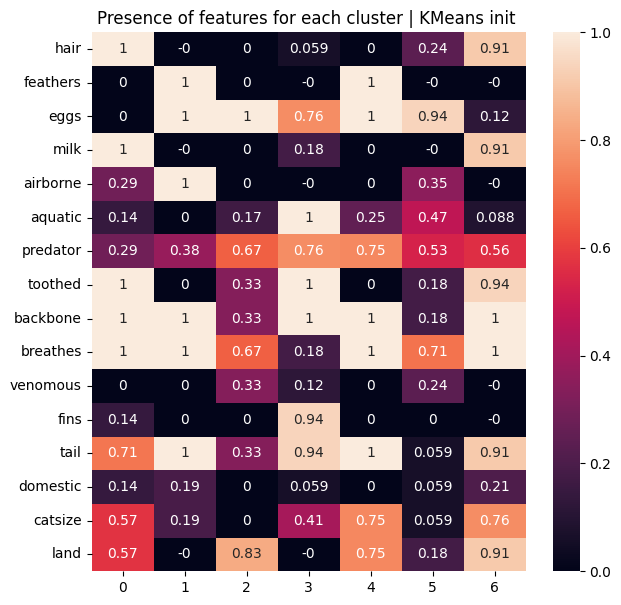

In [77]:
plot_chars_heatmap(np.round(centroids_clusters.drop(["label_cluster", "legs"], axis = 1), 6).T, 
                   "Presence of features for each cluster | KMeans init ")

In [78]:
dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment

{1: 'Bird',
 3: 'Fish',
 6: 'Mammal',
 5: 'Bug',
 4: 'Reptile',
 0: 'Amphibian',
 2: 'Invertebrate'}

In [79]:
classification_metrics(yhat, assignment)

,class_name,Accuracy,Precision,Specificity,Recall,F1
1,Bird,0.960396,1.000000,1.000000,0.800000,0.888889
3,Fish,0.960396,0.764706,0.954545,1.000000,0.866667
6,Mammal,0.871287,0.911765,0.950000,0.756098,0.826667
5,Bug,0.910891,0.470588,0.903226,1.000000,0.640000
4,Reptile,0.910891,0.000000,0.958333,0.000000,0.000000
0,Amphibian,0.891089,0.000000,0.927835,0.000000,0.000000
2,Invertebrate,0.920792,0.666667,0.978022,0.400000,0.500000


In [80]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        0                     7             1   
             1                        3                     3             1   
             1                        6                    31             1   
Bird         2                        1                    16             2   
             2                        4                     4             2   
Reptile      3                        2                     2             3   
             3                        3                     1             3   
             3                        6                     2             3   
Fish         4                        3                    13             4   
Amphibian    5                        5                     3             5   
             5                        6                     1             5   
Bug          6                        5                     8             6   
Invertebrate 7                        2                     4             7   
             7                        5                     6             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.171  
             1                            41                       0.073  
             1                            41                       0.756  
Bird         2                            20                       0.800  
             2                            20                       0.200  
Reptile      3                             5                       0.400  
             3                             5                       0.200  
             3                             5                       0.400  
Fish         4                            13                       1.000  
Amphibian    5                             4                       0.750  
             5                             4                       0.250  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.600

## Aglomerative Clustering

In [82]:
agclu = AgglomerativeClustering(n_clusters= k)
y_pred = agclu.fit_predict(X)

In [83]:
y_pred

array([4, 4, 2, 4, 4, 4, 4, 2, 2, 4, 4, 3, 2, 6, 0, 0, 3, 4, 2, 2, 3, 3,
       4, 3, 1, 0, 0, 5, 4, 5, 1, 4, 5, 3, 2, 4, 4, 3, 2, 1, 1, 3, 1, 3,
       4, 4, 0, 4, 4, 4, 4, 1, 0, 1, 4, 4, 3, 3, 3, 3, 2, 2, 6, 4, 4, 4,
       2, 4, 4, 4, 4, 3, 1, 2, 2, 5, 6, 6, 3, 3, 6, 6, 2, 3, 5, 0, 2, 3,
       1, 0, 0, 0, 2, 5, 4, 3, 5, 1, 4, 6, 3])

In [85]:
yhat, comp_table = create_comparation_table_clustering(y_pred, X, labels, dict_class_types, class_label)

centroids_clusters_agclu = yhat.drop(["class_name"], axis = 1).groupby(["cluster_label"]).mean()[X.columns]
centroids_clusters_agclu = pd.DataFrame(data = np.array(centroids_clusters_agclu), 
             index = list(centroids_clusters_agclu.index),
             columns = centroids_clusters_agclu.columns)

centroids_clusters, centroids_classes = aggregate_features_cluster_centers(zm, X.columns, 
                                                                        np.array(centroids_clusters_agclu),
                                                                        list(centroids_clusters_agclu.index))

dmatrix = compute_distance_matrix(centroids_clusters.set_index("label_cluster"), centroids_classes)
assignment = assign_clusters_distance(dmatrix)
assignment_new_label = dict(zip(assignment.keys(),[f'{x[0]} ({x[1]})' for x in assignment.items()]))
gb_clusters = centroids_clusters.drop(["legs", "label_cluster"], axis = 1)
gb_clusters.index = [assignment_new_label[i] for i in centroids_clusters["label_cluster"]]
assignment
assignment_new_label

{3: '3 (Bird)',
 2: '2 (Fish)',
 1: '1 (Bug)',
 4: '4 (Mammal)',
 0: '0 (Amphibian)',
 6: '6 (Reptile)',
 5: '5 (Invertebrate)'}

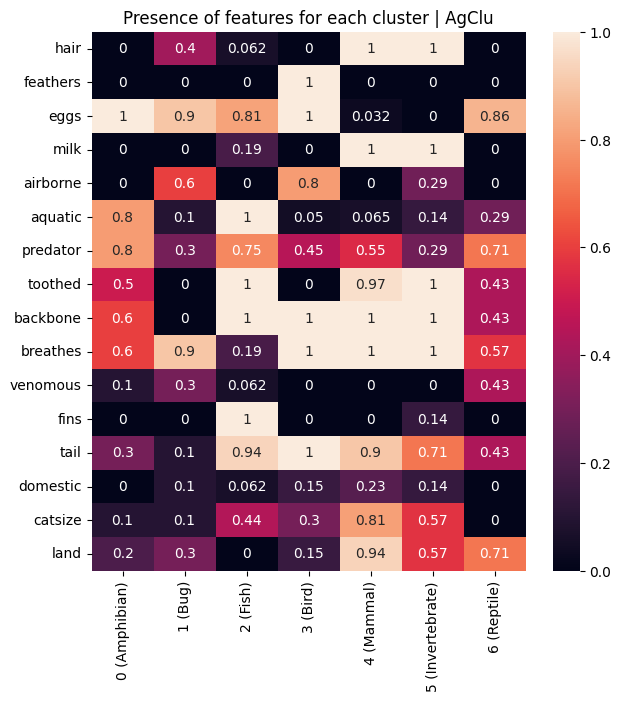

In [86]:
plot_chars_heatmap(gb_clusters.T, 
                   "Presence of features for each cluster | AgClu")

In [87]:
classification_metrics(yhat, assignment)

,class_name,Accuracy,Precision,Specificity,Recall,F1
3,Bird,1.000000,1.000000,1.000000,1.000000,1.000000
2,Fish,0.970297,0.812500,0.965909,1.000000,0.896552
1,Bug,0.980198,0.800000,0.978495,1.000000,0.888889
4,Mammal,0.900990,1.000000,1.000000,0.756098,0.861111
0,Amphibian,0.940594,0.400000,0.938144,1.000000,0.571429
6,Reptile,0.940594,0.428571,0.958333,0.600000,0.500000
5,Invertebrate,0.831683,0.000000,0.923077,0.000000,0.000000


In [88]:
comp_table

cluster_label  cluster_total_number  Class_Number  \
class_name   class_label                                                      
Mammal       1                        2                     3             1   
             1                        4                    31             1   
             1                        5                     7             1   
Bird         2                        3                    20             2   
Reptile      3                        0                     2             3   
             3                        6                     3             3   
Fish         4                        2                    13             4   
Amphibian    5                        0                     4             5   
Bug          6                        1                     8             6   
Invertebrate 7                        0                     4             7   
             7                        1                     2             7   
             7                        6                     4             7   

                          class_total_number  presence_relative_to_class  
class_name   class_label                                                  
Mammal       1                            41                       0.073  
             1                            41                       0.756  
             1                            41                       0.171  
Bird         2                            20                       1.000  
Reptile      3                             5                       0.400  
             3                             5                       0.600  
Fish         4                            13                       1.000  
Amphibian    5                             4                       1.000  
Bug          6                             8                       1.000  
Invertebrate 7                            10                       0.400  
             7                            10                       0.200  
             7                            10                       0.400